In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib



In [9]:
df = pd.read_csv("../../data/Salary_Data.csv")
df_original = df.copy()
print("Rows after loading:", len(df))

df.dropna(inplace=True)   # Remove missing values
print("Rows after removing missing values:", len(df))

def clean_text(text):
    if isinstance(text, str):
        text = text.strip().lower()
        text = text.replace("’", "'")
        text = text.replace(" degree", "")  # Remove word 'degree'
        text = text.replace("bachelors", "bachelor's")
        text = text.replace("masters", "master's")
        text = text.replace("phd", "phd")
        
    return text

df['Education Level'] = df['Education Level'].apply(clean_text)
print("Cleaned Education Levels:", df['Education Level'].unique())


df.drop_duplicates(inplace=True)  # Remove duplicate rows
print("Rows after removing duplicates:", len(df))

Rows after loading: 6704
Rows after removing missing values: 6698
Cleaned Education Levels: ["bachelor's" "master's" 'phd' 'high school']
Rows after removing duplicates: 1786


In [10]:
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_cleaned = remove_outliers_iqr(df, ['Salary'])
df_cleaned = df_cleaned[df_cleaned['Salary'] > 1000]  # Keep realistic values
df_cleaned = df_cleaned.reset_index(drop=True)
print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")
df.duplicated().sum()

Original rows: 1786, Cleaned rows: 1782


np.int64(0)

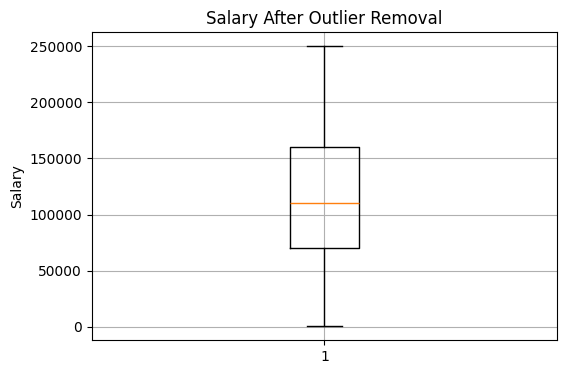

In [11]:
# Boxplot after outlier removal
plt.figure(figsize=(6, 4))
plt.boxplot(df["Salary"])
plt.title("Salary After Outlier Removal")
plt.ylabel("Salary")
plt.grid(True)
plt.show()

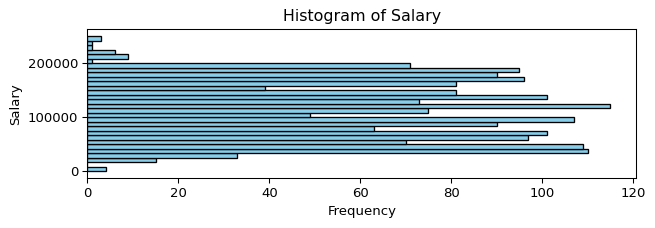

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Select only numerical columns
numeric_cols = ["Salary"]

# Create one subplot per numeric column
fig, axs = plt.subplots(len(numeric_cols), 1, dpi=95, figsize=(7, len(numeric_cols) * 2.5))

# Loop through each column and plot its histogram
for i, col in enumerate(numeric_cols):
    # Check if axs is a single Axes object or an array of Axes objects
    if len(numeric_cols) == 1:
        current_ax = axs
    else:
        current_ax = axs[i]

    current_ax.hist(df[col], bins=30, color='skyblue', edgecolor='black', orientation='horizontal') # Set orientation='horizontal' for horizontal histograms
    current_ax.set_title(f"Histogram of {col}")
    current_ax.set_xlabel("Frequency") # Swap xlabel and ylabel for horizontal
    current_ax.set_ylabel(col) # Swap xlabel and ylabel for horizontal

plt.tight_layout()
plt.show()

The distribution is not a normal distribution (bell curve). Instead, it appears somewhat multimodal (having multiple peaks) or broadly uniform across the middle range.

In [13]:
from scipy.stats import skew, kurtosis

print("Skewness:", skew(df['Salary']))
print("Kurtosis:", kurtosis(df['Salary']))

print("Original dataset size:", df_original.shape)
print("After removing outliers:", df.shape)
print(df.describe())


Skewness: 0.07682250537129963
Kurtosis: -1.1192375859586496
Original dataset size: (6704, 6)
After removing outliers: (1786, 6)
               Age  Years of Experience         Salary
count  1786.000000          1786.000000    1786.000000
mean     35.142217             9.159015  113220.037514
std       8.214760             6.845753   51589.303161
min      21.000000             0.000000     350.000000
25%      29.000000             3.000000   70000.000000
50%      33.000000             8.000000  110000.000000
75%      41.000000            13.000000  160000.000000
max      62.000000            34.000000  250000.000000


- Skewness (~0.077): Near Perfect Symmetry

- Kurtosis (~ -1.12): Flat Distribution

- (A negative kurtosis means the distribution is flatter than a standard Bell Curve.) - There is high variance in the job market.

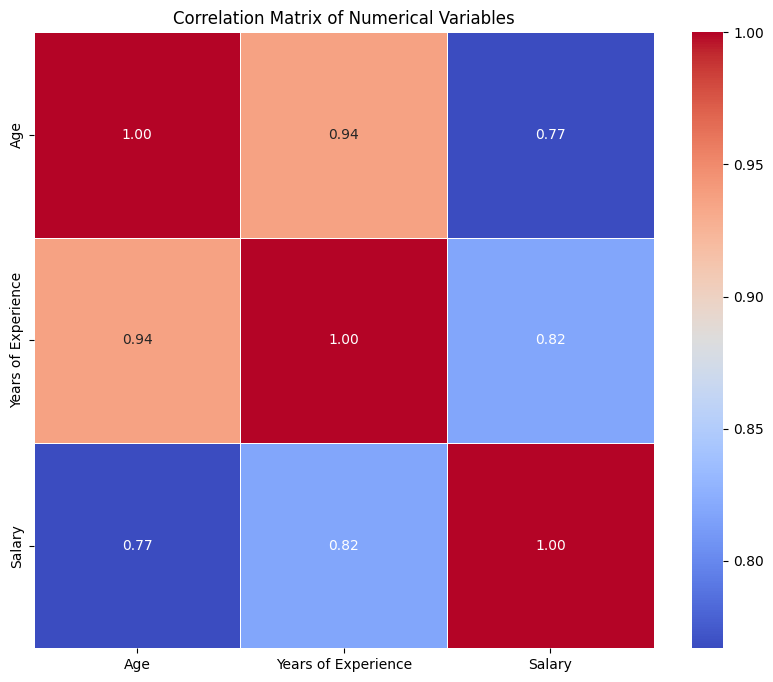

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation calculation
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [15]:
# Split features and target
X = df_cleaned.drop('Salary', axis=1)
y = df_cleaned['Salary']

# Stratified split on Gender to maintain distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Gender']
)



In [16]:
# Handle rare categories
threshold = 10
for col in ['Job Title', 'Education Level']:
    top_categories = X_train[col].value_counts().loc[lambda x: x >= threshold].index
    X_train[col] = X_train[col].where(X_train[col].isin(top_categories), 'Other')
    X_test[col] = X_test[col].where(X_test[col].isin(top_categories), 'Other')

# Preprocessing pipeline
numerical_cols = ['Age', 'Years of Experience']
categorical_cols = ['Gender', 'Education Level', 'Job Title']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        subsample=0.9, 
        reg_lambda=10,
        reg_alpha=0.5,
        random_state=42, 
        n_estimators=1000, 
        max_depth=5,
        learning_rate=0.1, 
        gamma=0.1, 
        colsample_bytree=1.0,
        verbosity=0
    ))
])

# K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
print(f"Mean CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Fit model
model.fit(X_train, y_train)



Mean CV R²: 0.888 (+/- 0.016)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation function
def evaluate_detailed(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"RMSE: LKR {rmse:,.2f}")
    print(f"R²: {r2:.3f}")
    print(f"MAE: LKR {mae:,.2f}")
    
    return rmse, r2, mae

train_metrics = evaluate_detailed(y_train, y_train_pred, "Training")
test_metrics = evaluate_detailed(y_test, y_test_pred, "Testing")




Training Metrics:
RMSE: LKR 7,771.11
R²: 0.977
MAE: LKR 5,151.74

Testing Metrics:
RMSE: LKR 15,921.17
R²: 0.909
MAE: LKR 10,465.68


- The model shows strong predictive capability but there are signs of overfitting, meaning it performs significantly better on data it has seen than on new, unseen data.

- The model explains approximately 91% of the variance in salaries for new data.

- The model has memorized noise or specific details in the training set that do not apply to the test set.

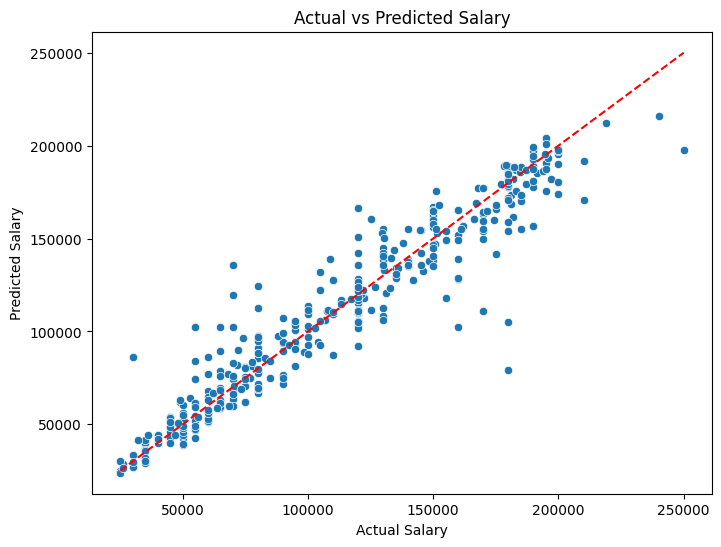

In [18]:
# Plot: Actual vs Predicted salaries
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")
plt.show()



- The data points are tightly clustered and follow the red line closely across the entire range.:- The model has successfully captured the underlying relationship between the features and the target variable (Salary).

- The tight clustering holds true from the lowest salaries (around 25,000) up to the highest points (around 200,000).:- The model is robust and does not perform significantly better or worse on any specific salary bracket.

- As the Actual Salary approaches the maximum values (225,000 to 250,000), several points fall below the line.:- The model tends to under-predict the highest salaries in the dataset.

- The vertical distance of any point from the red line represents the model's error for that prediction.:- The small distances visually confirm the low RMSE and MAE, demonstrating minimal overall prediction error.

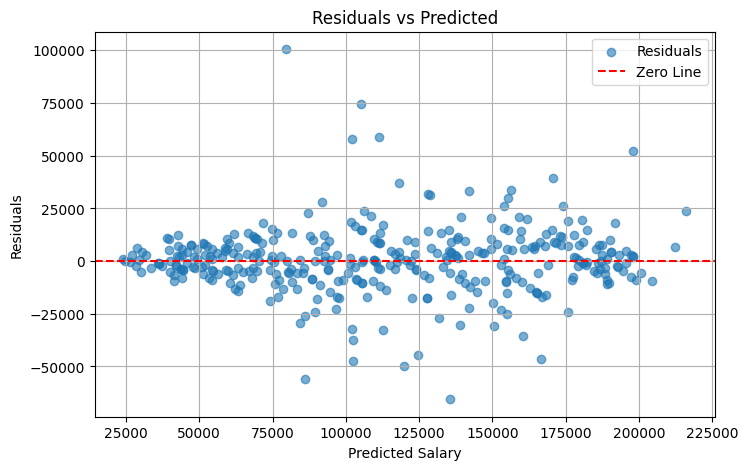

In [20]:
# Plot Residuals - Visualize the errors between predicted and actual values.
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.legend(['Residuals', 'Zero Line'])
plt.grid(True)
plt.show()


- The red dashed line represents a residual of zero. Points above the line mean the model under-predicted the salary (Actual > Predicted). Points below the line mean the model over-predicted the salary (Actual < Predicted).

- The residuals are generally centered around the zero line across most of the predicted salary range, which is a positive indicator of an unbiased model.

- Low to Mid-Range (LKR 25,000 to ~150,000): The residuals are tightly packed around the zero line. The spread (or vertical distance) of the points is relatively consistent. This is good evidence of homoscedasticity in this range.

- Mid to High-Range (LKR 150,000 and up): The spread of the residuals increases slightly, particularly around the LKR 175,000 to LKR 200,000 mark. There are more positive outliers (under-predictions) here, though the effect is minor.

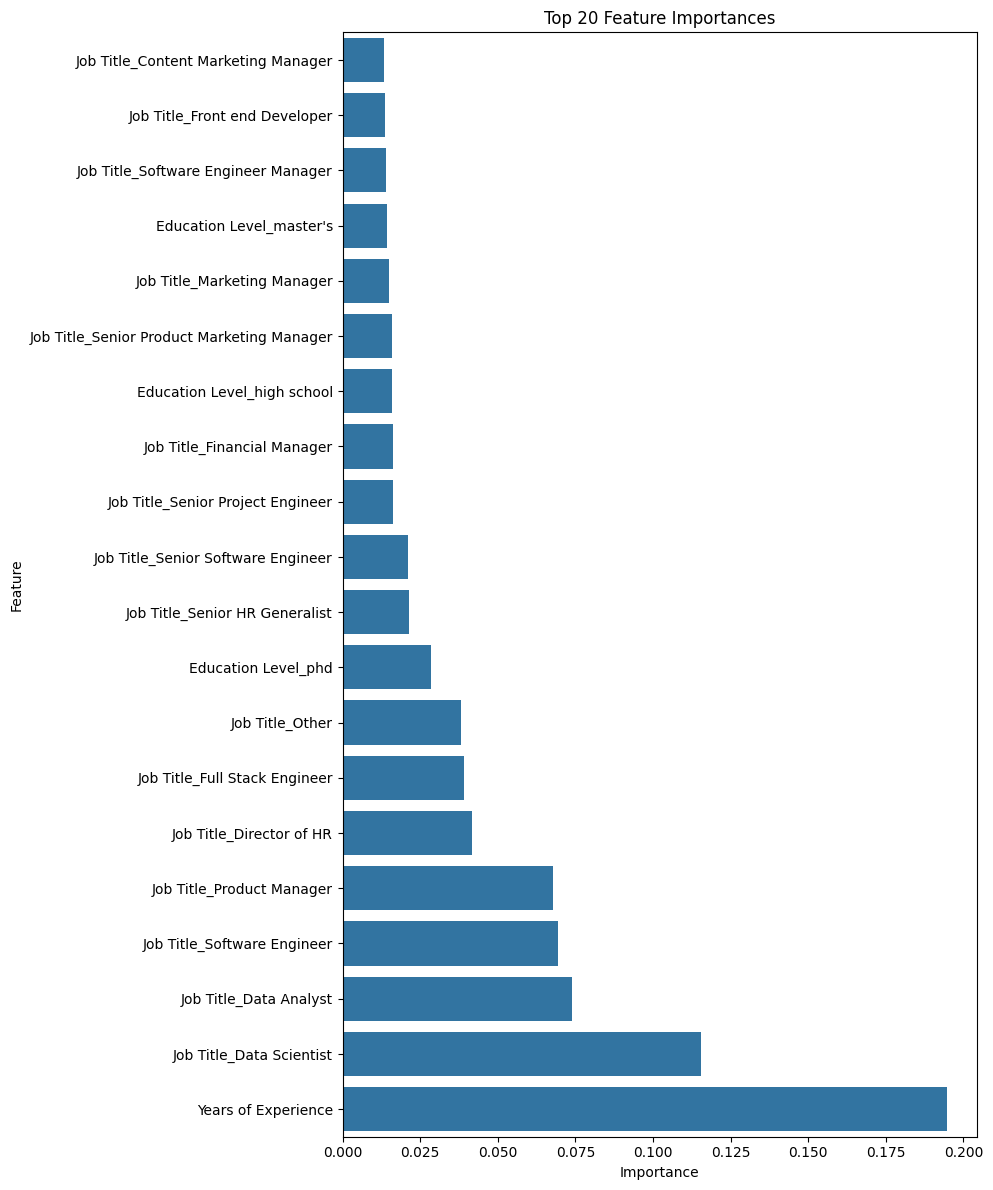

In [21]:

# Extract RandomForest regressor from pipeline
reg = model.named_steps['regressor']

# Get numeric + one-hot encoded feature names
cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_features)
importances = reg.feature_importances_

# Create Series and sort
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Plot top 20 features for clarity
top_n = 20
plt.figure(figsize=(10, 0.5*top_n + 2))  # Dynamically adjust figure height
sns.barplot(x=feat_imp.values[-top_n:], y=feat_imp.index[-top_n:])
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



In [22]:
# Predict salary for new input
# Example input
new_employee = pd.DataFrame({
    'Age': [30],
    'Years of Experience': [5],
    'Gender': ['Male'],
    'Education Level': ['Bachelor'],
    'Job Title': ['Data Analyst']
})

predicted_salary = model.predict(new_employee)[0]
print(f"\nPredicted Salary for the new employee: LKR {predicted_salary:,.2f}")


Predicted Salary for the new employee: LKR 154,970.80


/opt/conda/envs/ml-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [23]:
# Save the trained model
joblib.dump(model, "/workspaces/CS_Group_09_Salary_prediction/models/XGBoost.pkl")
print("\nModel saved as XGBoost.pkl")


Model saved as XGBoost.pkl
